#Multimodal Multimodular RAG for Drone Technology
copyright 2024, Denis Rothman

The goal of this educational notebook is to have a working understanding of how to build a RAG system that can process and understand both text and image data to answer questions about drone technology.

The program implements:

* Large Language Models (LLMs) to process and understand text about drones.
   
* Multimodal datasets containing images and labels of drones.
   
* Functions to display images and identify objects within them using bounding boxes.
   
* Builds a system that can answer questions about drone technology using both text and images.
   





# Environment Setup

**Prerequisites:**
- Python 3.12+
- `.env` file with `OPENAI_API_KEY`
- Chapter 3 completed (ChromaDB collection created)

**Key Configuration:**
```python
CHROMA_PATH = "../Chapter03/chroma_db"
COLLECTION_NAME = "drone_vision"
MODEL = "gpt-4o"
SAMPLE_LIMIT = len(ds)  # Process all 6,471 images
```

In [151]:
# Import required modules
from llama_index.core import VectorStoreIndex, SimpleDirectoryReader, Document
import os
from dotenv import load_dotenv

# Load environment variables from .env file
load_dotenv()

# Set OpenAI API key
os.environ['OPENAI_API_KEY'] = os.getenv("OPENAI_API_KEY")

# Validate API key is present
if not os.getenv("OPENAI_API_KEY"):
    raise ValueError("OPENAI_API_KEY not found in .env file. Please create a .env file with your API key.")

print("✓ Environment configured successfully")

✓ Environment configured successfully


# Loading the LLM Dataset from ChromaDB

This section loads the pre-embedded LLM dataset from the ChromaDB vector store created in Chapter 3.

The embedded data includes:
- **Embeddings**: 1536-dimensional vectors from OpenAI text-embedding-3-small
- **IDs**: Unique string identifiers for each chunk
- **Metadata**: Source file information (file_path, file_name, etc.)
- **Text**: The actual content of each chunk

In [152]:
import chromadb
import pandas as pd
import numpy as np

# ChromaDB configuration (from Chapter 3)
CHROMA_PATH = "../Chapter03/chroma_db"
COLLECTION_NAME = "drone_vision"

# Connect to existing ChromaDB
print(f"Connecting to ChromaDB at: {CHROMA_PATH}")
chroma_client = chromadb.PersistentClient(path=CHROMA_PATH)

# Load the collection
try:
    chroma_collection = chroma_client.get_collection(name=COLLECTION_NAME)
    print(f"✓ Loaded collection: {COLLECTION_NAME}")
    print(f"  Total embedded chunks: {chroma_collection.count()}")
except Exception as e:
    error_msg = (
        f"ChromaDB collection {COLLECTION_NAME} not found!\n"
        f"Please run Chapter 3 notebooks first to create the embedded dataset.\n"
        f"Error: {e}"
    )
    raise FileNotFoundError(error_msg)

Connecting to ChromaDB at: ../Chapter03/chroma_db
✓ Loaded collection: drone_vision
  Total embedded chunks: 150


In [153]:
# Retrieve all data from ChromaDB
results = chroma_collection.get(
    include=["documents", "metadatas", "embeddings"]
)

# Create DataFrame with the structure you requested
# Column order: embedding, id, metadata, text
# Use row-by-row construction to avoid pandas dimension issues
data_rows = []
for i in range(len(results['ids'])):
    row = {
        'embedding': results['embeddings'][i],
        'id': results['ids'][i],
        'metadata': results['metadatas'][i],
        'text': results['documents'][i][:200] + '...' if len(results['documents'][i]) > 200 else results['documents'][i]
    }
    data_rows.append(row)

df_llm = pd.DataFrame(data_rows)

print(f"\nLoaded embedded dataset:")
print(f"  Total chunks: {len(df_llm)}")
print(f"  Embedding dimensions: {len(df_llm['embedding'].iloc[0]) if len(df_llm) > 0 else 0}")
print(f"  Unique source files: {len(set(m.get('file_name', 'unknown') for m in results['metadatas']))}")
print(f"\nDataFrame columns (in order): {list(df_llm.columns)}")
print(f"DataFrame shape: {df_llm.shape}")

# Display the DataFrame
df_llm


Loaded embedded dataset:
  Total chunks: 150
  Embedding dimensions: 1536
  Unique source files: 22

DataFrame columns (in order): ['embedding', 'id', 'metadata', 'text']
DataFrame shape: (150, 4)


embedding  \
0    [-0.0060118418186903, 0.00712487893179059, -0....   
1    [-0.003963915631175041, 0.004719626158475876, ...   
2    [-0.013745967298746109, -0.005453375168144703,...   
3    [-0.012644695118069649, -0.014721737243235111,...   
4    [-0.012832589447498322, -0.012225455604493618,...   
..                                                 ...   
145  [-0.015432015061378479, 0.01777665875852108, 0...   
146  [-0.013848980888724327, 0.005735330283641815, ...   
147  [-0.011834381148219109, 0.001806560205295682, ...   
148  [-0.017790183424949646, 0.008951478637754917, ...   
149  [-0.007632681634277105, 0.0011516922386363149,...   

                                       id  \
0    49fb4303-39d0-47cb-902c-4d94c95093bb   
1    214a7478-cd09-476d-8989-bc3a5654fc23   
2    2e82c555-4972-420b-8704-d652f2fda6cc   
3    b057b5ba-dbd6-4e2f-ab76-c6eb8f5dc3df   
4    b31b3e67-2998-400f-9f1c-313020a44709   
..                                    ...   
145  ff81fa63-a5de-4078-be0e-8e98cf5c68b1   
146  1ac33784-4696-4a3c-b268-8163616d3ea3   
147  faa0313f-f844-4084-8f5f-5b4cad011724   
148  24357b80-a503-49ec-b1b3-fa1bc3345312   
149  b24123db-97d4-4f32-9bcc-cee3e1c44b89   

                                              metadata  \
0    {'file_size': 454, 'last_modified_date': '2025...   
1    {'file_type': 'text/plain', 'document_id': '45...   
2    {'file_size': 2009, 'file_name': 'article_10.t...   
3    {'last_modified_date': '2025-10-30', 'file_nam...   
4    {'doc_id': 'c3cd1a25-f7e4-4091-a862-7bca5df675...   
..                                                 ...   
145  {'file_path': 'c:\Users\user\Desktop\RAG-Drive...   
146  {'file_size': 78972, 'creation_date': '2025-10...   
147  {'doc_id': 'e65f9c52-2421-4ef1-b3fd-758affe287...   
148  {'last_modified_date': '2025-10-30', 'file_nam...   
149  {'creation_date': '2025-10-30', 'document_id':...   

                                                  text  
0    arXivLabs is a framework that allows collabora...  
1    arXivLabs is a framework that allows collabora...  
2    TensorFlow makes it easy to create ML models t...  
3    Choose Your Path: Install PyTorch Locally or L...  
4    Keras is a deep learning API designed for huma...  
..                                                 ...  
145  We replace RoIPooling with RoIAlign  to perfor...  
146  TPAMI 26(11), 1475–1490 (2004)\r\n2. Andriluka...  
147  Everingham, M., Eslami, S.M.A., Gool, L.J.V., ...  
148  : Feature\r\npyramid networks for object detec...  
149  IJCV 115(3), 211–252 (2015)\r\n42. Shrivastava...  

[150 rows x 4 columns]

In [154]:
# Convert ChromaDB data to LlamaIndex Document objects
from llama_index.core import Document

documents_llm = []
for i in range(len(results['ids'])):
    # Clean metadata - remove large fields that cause chunk size issues
    clean_metadata = {}
    for key, value in results['metadatas'][i].items():
        # Skip large internal fields
        if key not in ['_node_content', '_node_type']:
            clean_metadata[key] = value
    
    # Create Document object with full text and cleaned metadata
    doc = Document(
        text=results['documents'][i],
        doc_id=results['ids'][i],
        metadata=clean_metadata
    )
    documents_llm.append(doc)

print(f"\n✓ Created {len(documents_llm)} LlamaIndex Document objects")
print(f"  Metadata cleaned (removed large internal fields)")
print(f"  Ready for vector store index creation")


✓ Created 150 LlamaIndex Document objects
  Metadata cleaned (removed large internal fields)
  Ready for vector store index creation


In [155]:
# Display a sample record with full details
sample_idx = 142

print("="*80)
print(f"SAMPLE RECORD (index {sample_idx})")
print("="*80)
print("\nID:")
print(f"  {df_llm.iloc[sample_idx]['id']}")
print("\nMetadata:")
for key, value in df_llm.iloc[sample_idx]['metadata'].items():
    print(f"  {key}: {value}")
print("\nText (truncated):")
print(f"  {df_llm.iloc[sample_idx]['text']}")
print("\nEmbedding (first 10 dimensions):")
print(f"  {df_llm.iloc[sample_idx]['embedding'][:10]}")
print(f"  ... (total {len(df_llm.iloc[sample_idx]['embedding'])} dimensions)")
print("="*80)

SAMPLE RECORD (index 142)

ID:
  6697325c-9258-4f3b-8143-b9983facafd0

Metadata:
  file_size: 78972
  file_path: c:\Users\user\Desktop\RAG-Driven-Generative-AI\Chapter03\data\Zhu_VisDrone-DET2018_The_Vision_Meets_Drone_Object_Detection_in_Image_Challenge_ECCVW_2018_paper.txt
  doc_id: e65f9c52-2421-4ef1-b3fd-758affe28792
  last_modified_date: 2025-10-30
  _node_content: {"id_": "6697325c-9258-4f3b-8143-b9983facafd0", "embedding": null, "metadata": {"file_path": "c:\\Users\\user\\Desktop\\RAG-Driven-Generative-AI\\Chapter03\\data\\Zhu_VisDrone-DET2018_The_Vision_Meets_Drone_Object_Detection_in_Image_Challenge_ECCVW_2018_paper.txt", "file_name": "Zhu_VisDrone-DET2018_The_Vision_Meets_Drone_Object_Detection_in_Image_Challenge_ECCVW_2018_paper.txt", "file_type": "text/plain", "file_size": 78972, "creation_date": "2025-10-30", "last_modified_date": "2025-10-30"}, "excluded_embed_metadata_keys": ["file_name", "file_type", "file_size", "creation_date", "last_modified_date", "last_accessed_dat

## Initializing the LLM Query Engine

In [156]:
from llama_index.core import VectorStoreIndex

# Create VectorStoreIndex from documents_llm
# Note: This will re-embed the documents (not using ChromaDB's existing embeddings)
vector_store_index_llm = VectorStoreIndex.from_documents(documents_llm)

print(f"✓ Created VectorStoreIndex from {len(documents_llm)} documents")
print(f"  Index is ready for querying")

✓ Created VectorStoreIndex from 150 documents
  Index is ready for querying


In [157]:
vector_query_engine_llm = vector_store_index_llm.as_query_engine(similarity_top_k=2, temperature=0.1, num_output=1024)

### User input for multimodular modular RAG

Modular RAG with multiple modalities (text, images) and sources of information; in this case, two datasets.

In [158]:
user_input="How do drones identify a truck?"

In [159]:
import time
import textwrap
#start the timer
start_time = time.time()
llm_response = vector_query_engine_llm.query(user_input)
# Stop the timer
end_time = time.time()
# Calculate and print the execution time
elapsed_time = end_time - start_time
print(f"Query execution time: {elapsed_time:.4f} seconds")

print(textwrap.fill(str(llm_response), 100))

Query execution time: 2.0234 seconds
Drones can identify a truck through various means such as using computer vision technology, sensors
like Lidar, and other imaging techniques.


# Loading and visualizing the multimodal dataset



In [160]:
import deeplake

dataset_path = 'hub://activeloop/visdrone-det-train'
ds = deeplake.load(dataset_path) # Returns a Deep Lake Dataset but does not download data locally

\

Opening dataset in read-only mode as you don't have write permissions.


|

This dataset can be visualized in Jupyter Notebook by ds.visualize() or at https://app.activeloop.ai/activeloop/visdrone-det-train



\

hub://activeloop/visdrone-det-train loaded successfully.



In [161]:
len(ds)

6471

In [162]:
ds.summary()

Dataset(path='hub://activeloop/visdrone-det-train', read_only=True, tensors=['boxes', 'images', 'labels'])

 tensor      htype                 shape               dtype  compression
 -------    -------               -------             -------  ------- 
  boxes      bbox            (6471, 1:914, 4)         float32   None   
 images      image     (6471, 360:1500, 480:2000, 3)   uint8    jpeg   
 labels   class_label          (6471, 1:914)          uint32    None   


In [163]:
ds.visualize()

In [ ]:
import pandas as pd

# Create an empty DataFrame with the defined structure
df = pd.DataFrame(columns=['image', 'boxes', 'labels'])

# Limit to first 100 samples for faster processing (change to len(ds) for full dataset)
# SAMPLE_LIMIT = 100  # Set to len(ds) to process all 6,471 images
SAMPLE_LIMIT = len(ds)

# Iterate through the samples using enumerate
for i, sample in enumerate(ds):
    if i >= SAMPLE_LIMIT:
        break
    
    # Image data (choose either path or compressed representation)
    # df.loc[i, 'image'] = sample.images.path  # Store image path
    df.loc[i, 'image'] = sample.images.tobytes()  # Store compressed image data
    
    # Bounding box data (as a list of lists)
    boxes_list = sample.boxes.numpy(aslist=True)
    df.loc[i, 'boxes'] = [box.tolist() for box in boxes_list]
    
    # Label data (as a list)
    label_data = sample.labels.data()
    df.loc[i, 'labels'] = label_data['text']

In [165]:
print(f"✓ Loaded {len(df)} samples (limited to {SAMPLE_LIMIT})")
df

✓ Loaded 6471 samples (limited to 6471)


image  \
0     b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x01\x00...   
1     b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x01\x00...   
2     b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x01\x00...   
3     b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x01\x00...   
4     b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x01\x00...   
...                                                 ...   
6466  b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x01\x00...   
6467  b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x01\x00...   
6468  b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x01\x00...   
6469  b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x01\x00...   
6470  b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x01\x00...   

                                                  boxes  \
0     [[1221.0, 84.0, 16.0, 33.0], [1235.0, 71.0, 18...   
1     [[351.0, 936.0, 305.0, 114.0], [0.0, 818.0, 22...   
2     [[699.0, 716.0, 26.0, 54.0], [600.0, 604.0, 22...   
3     [[417.0, 77.0, 57.0, 54.0], [387.0, 109.0, 31....   
4     [[794.0, 617.0, 97.0, 115.0], [803.0, 539.0, 7...   
...                                                 ...   
6466  [[683.0, 710.0, 7.0, 6.0], [681.0, 717.0, 5.0,...   
6467  [[1761.0, 676.0, 207.0, 155.0], [1539.0, 648.0...   
6468  [[0.0, 501.0, 105.0, 93.0], [412.0, 594.0, 172...   
6469  [[200.0, 604.0, 112.0, 64.0], [311.0, 560.0, 1...   
6470  [[60.0, 144.0, 16.0, 21.0], [51.0, 120.0, 15.0...   

                                                 labels doc_id  
0     [pedestrian, pedestrian, tricycle, pedestrian,...      0  
1     [car, car, car, car, car, car, car, car, car, ...      1  
2     [truck, car, van, car, car, car, car, car, car...      2  
3     [ignored regions, ignored regions, car, car, c...      3  
4     [car, car, car, car, car, car, car, car, car, ...      4  
...                                                 ...    ...  
6466  [car, car, car, car, awning-tricycle, car, car...   6466  
6467  [car, car, car, car, car, van, car, car, car, ...   6467  
6468  [car, van, pedestrian, pedestrian, pedestrian,...   6468  
6469  [van, truck, van, car, car, van, others, car, ...   6469  
6470  [people, pedestrian, others, people, people, m...   6470  

[6471 rows x 4 columns]

In [166]:
labels_list = ds.labels.info['class_names']
labels_list

['ignored regions',
 'pedestrian',
 'people',
 'bicycle',
 'car',
 'van',
 'truck',
 'tricycle',
 'awning-tricycle',
 'bus',
 'motor',
 'others']

# Navigating the multimodal dataset structure

## Selecting an image

In [167]:
# Select an image index for exploration
ind = 0  # First image in the dataset

In [168]:
from IPython.display import display
from PIL import Image
import cv2  # Import OpenCV

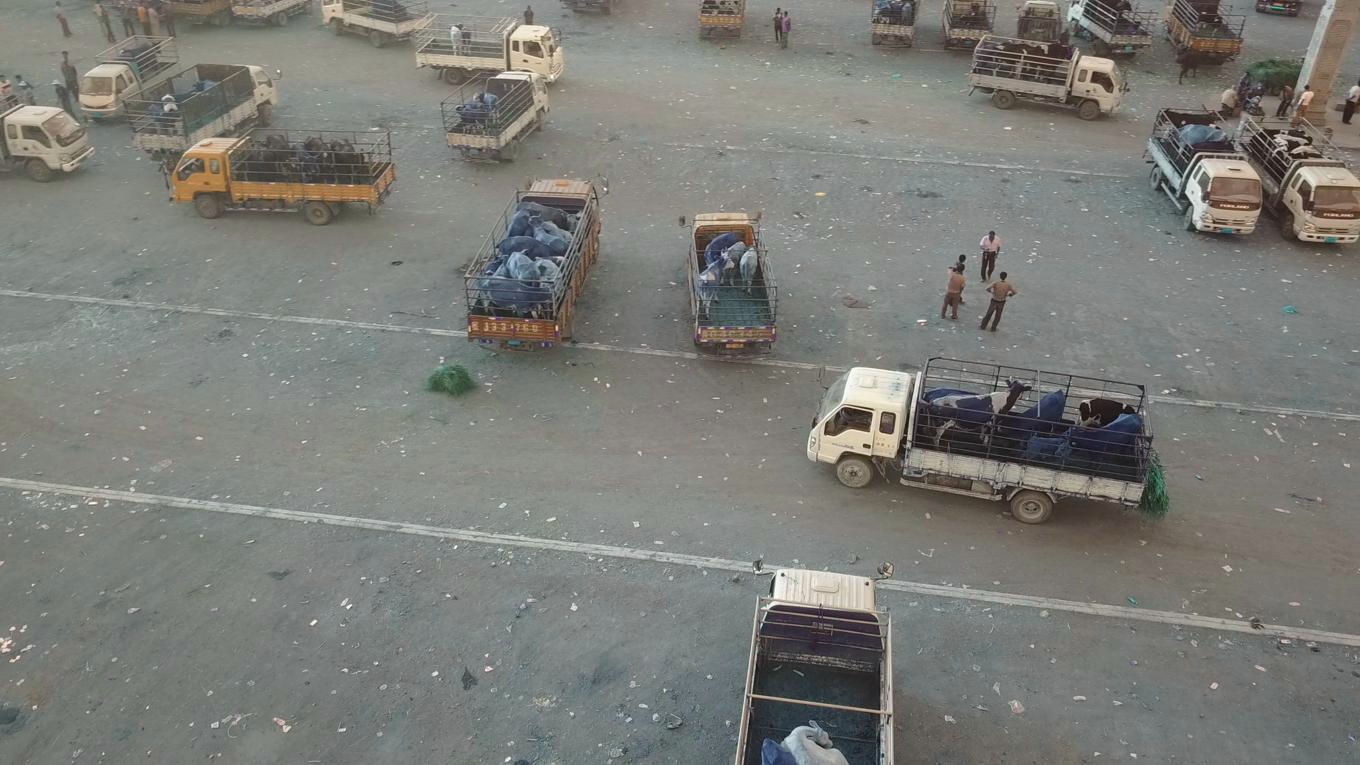

In [169]:
image = ds.images[0].numpy()

# Convert from BGR to RGB (if necessary)
image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

# Create PIL Image and display
# img = Image.fromarray(image)
img = Image.fromarray(image_rgb)
display(img)

## Adding Bounding boxes and saving the image

In [170]:
labels = ds.labels[ind].data() # Fetch the labels in the selected image
print(labels)

{'value': array([1, 1, 7, 1, 1, 1, 1, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 1, 6, 6, 6, 6,
       1, 1, 1, 1, 1, 1, 6, 6, 3, 6, 6, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 6, 6, 6], dtype=uint32), 'text': ['pedestrian', 'pedestrian', 'tricycle', 'pedestrian', 'pedestrian', 'pedestrian', 'pedestrian', 'truck', 'truck', 'truck', 'truck', 'truck', 'truck', 'truck', 'truck', 'truck', 'truck', 'pedestrian', 'truck', 'truck', 'truck', 'truck', 'pedestrian', 'pedestrian', 'pedestrian', 'pedestrian', 'pedestrian', 'pedestrian', 'truck', 'truck', 'bicycle', 'truck', 'truck', 'pedestrian', 'pedestrian', 'pedestrian', 'pedestrian', 'pedestrian', 'pedestrian', 'pedestrian', 'pedestrian', 'pedestrian', 'pedestrian', 'pedestrian', 'pedestrian', 'truck', 'truck', 'truck']}


In [171]:
values = labels['value']
text_labels = labels['text']

# Determine the maximum text label length for formatting
max_text_length = max(len(label) for label in text_labels)

# Print the header
print(f"{'Index':<10}{'Label':<{max_text_length + 2}}")
print("-" * (10 + max_text_length + 2))  # Add a separator line

# Print the indices and labels in two columns
for index, label in zip(values, text_labels):
    print(f"{index:<10}{label:<{max_text_length + 2}}")

Index     Label       
----------------------
1         pedestrian  
1         pedestrian  
7         tricycle    
1         pedestrian  
1         pedestrian  
1         pedestrian  
1         pedestrian  
6         truck       
6         truck       
6         truck       
6         truck       
6         truck       
6         truck       
6         truck       
6         truck       
6         truck       
6         truck       
1         pedestrian  
6         truck       
6         truck       
6         truck       
6         truck       
1         pedestrian  
1         pedestrian  
1         pedestrian  
1         pedestrian  
1         pedestrian  
1         pedestrian  
6         truck       
6         truck       
3         bicycle     
6         truck       
6         truck       
1         pedestrian  
1         pedestrian  
1         pedestrian  
1         pedestrian  
1         pedestrian  
1         pedestrian  
1         pedestrian  
1         pedestrian  
1         p

In [172]:
import io
from PIL import ImageDraw

def display_image_with_bboxes(image_data, bboxes, labels, label_name, ind=0):
    #Displays an image with bounding boxes for a specific label.

    image_bytes = io.BytesIO(image_data)
    img = Image.open(image_bytes)

    # Extract class names specifically for the selected image
    class_names = ds.labels[ind].info['class_names']

    # Filter for the specific label (or display all if class names are missing)
    if class_names is not None:
        try:
            label_index = class_names.index(label_name)
            relevant_indices = np.where(labels == label_index)[0]
        except ValueError:
            print(f"Warning: Label '{label_name}' not found. Displaying all boxes.")
            relevant_indices = range(len(labels))
    else:
        relevant_indices = []  # No labels found, so display no boxes

    # Draw bounding boxes
    draw = ImageDraw.Draw(img)
    for idx, box in enumerate(bboxes):  # Enumerate over bboxes
        if idx in relevant_indices:   # Check if this box is relevant
            x1, y1, w, h = box
            x2, y2 = x1 + w, y1 + h
            draw.rectangle([x1, y1, x2, y2], outline="red", width=2)
            draw.text((x1, y1), label_name, fill="red")
    # Save the image
    save_path="boxed_image.jpg"
    img.save(save_path)
    display(img)


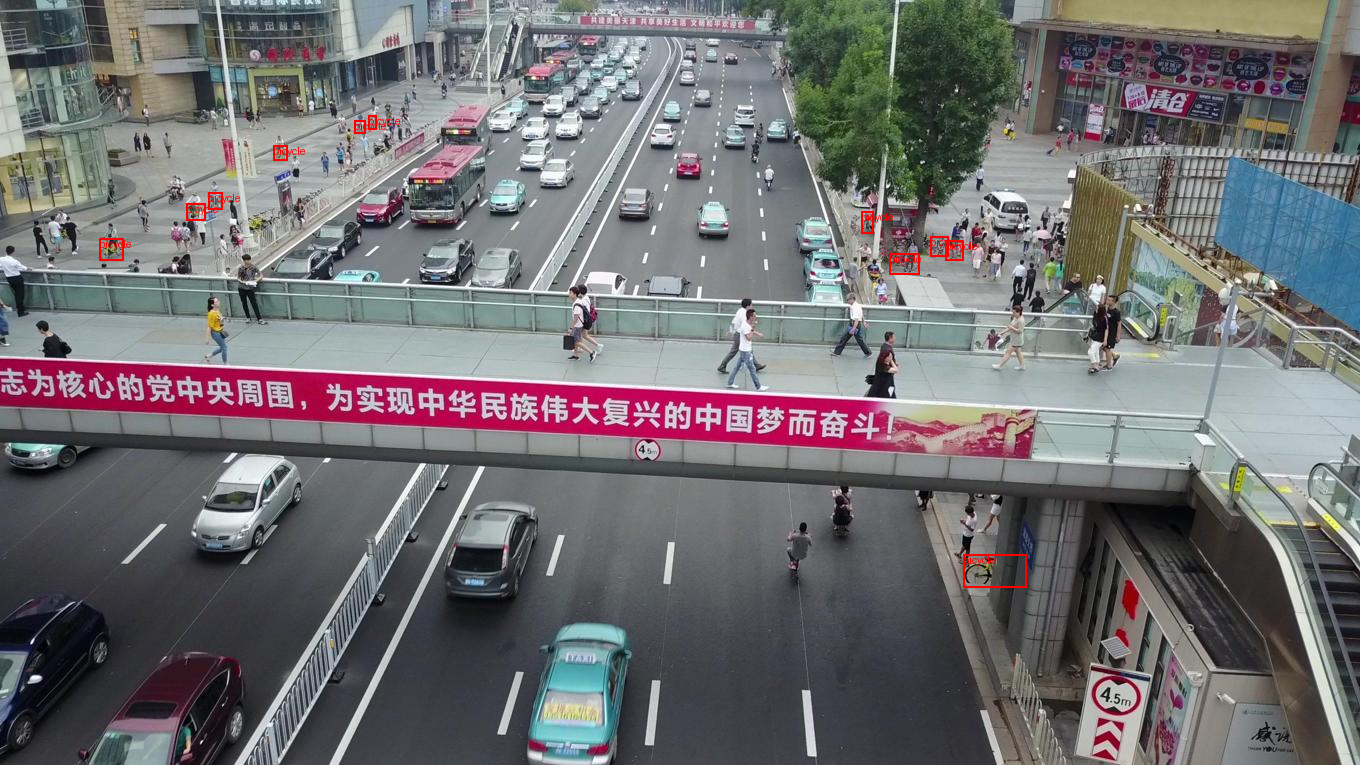

In [173]:
ind = 120

# Fetch labels and image data for the selected image
labels = ds.labels[ind].data()['value']
image_data = ds.images[ind].tobytes()
bboxes = ds.boxes[ind].numpy()
ibox="bicycle" # class in image

# Display the image with bounding boxes for the label chosen
display_image_with_bboxes(image_data, bboxes, labels, label_name=ibox)

# Building a multimodal search engine

In [174]:
# The DataFrame is named df
df["doc_id"] = df.index.astype(str)  # Create unique IDs from the row indices

# Create documents (extract relevant text for each image labels)
documents = []
for _, row in df.iterrows():
    text_labels = row["labels"] # Each label is now a string
    text = " ".join(text_labels) # Join text labels into a single string
    document = Document(text=text, doc_id=row["doc_id"])
    documents.append(document)

print(f"Created {len(documents)} documents from image labels")

Created 6471 documents from image labels


In [175]:
from llama_index.core import GPTVectorStoreIndex
vector_store_index = GPTVectorStoreIndex.from_documents(documents)

In [176]:
vector_query_engine = vector_store_index.as_query_engine(similarity_top_k=1, temperature=0.1, num_output=1024)

# Running a query on the VisDrone multimodel dataset

In [177]:
user_input="How do drones identify a pedestrian?"

In [178]:
import time
start_time = time.time()
response = vector_query_engine.query(user_input)
# Stop the timer
end_time = time.time()
# Calculate and print the execution time
elapsed_time = end_time - start_time
print(f"Query execution time: {elapsed_time:.4f} seconds")

Query execution time: 7.0866 seconds


In [179]:
# Save the multimodal response before it gets overwritten
multimodal_response = response
print(f"Saved multimodal response with {len(multimodal_response.source_nodes)} source nodes")

Saved multimodal response with 1 source nodes


In [180]:
print(textwrap.fill(str(response), 100))

Drones typically identify pedestrians using a combination of sensors such as cameras, LiDAR, and
radar. These sensors help the drone detect and track objects on the ground, allowing it to
differentiate between pedestrians and other obstacles or structures.


In [181]:
response.source_nodes

[NodeWithScore(node=TextNode(id_='6b22cc98-3fc7-48c3-8202-485239c1b86b', embedding=None, metadata={}, excluded_embed_metadata_keys=[], excluded_llm_metadata_keys=[], relationships={<NodeRelationship.SOURCE: '1'>: RelatedNodeInfo(node_id='3556', node_type='4', metadata={}, hash='736703c865de399f3bbe5bfc17ca7aa25997e41101a659c321284d21ece24131')}, metadata_template='{key}: {value}', metadata_separator='\n', text='pedestrian pedestrian', mimetype='text/plain', start_char_idx=0, end_char_idx=21, metadata_seperator='\n', text_template='{metadata_str}\n\n{content}'), score=0.8349473140735769)]

In [182]:
import json

# Convert response.source_nodes to JSON format
source_nodes_json = []
for node_with_score in response.source_nodes:
    node_dict = {
        'node_id': node_with_score.node.id_,
        'score': node_with_score.score,
        'text': node_with_score.node.text,
        'metadata': node_with_score.node.metadata,
        'relationships': {
            str(k): {
                'node_id': v.node_id,
                'node_type': v.node_type
            } for k, v in node_with_score.node.relationships.items()
        }
    }
    source_nodes_json.append(node_dict)

# Display as formatted JSON
print(json.dumps(source_nodes_json, indent=2))

[
  {
    "node_id": "6b22cc98-3fc7-48c3-8202-485239c1b86b",
    "score": 0.8349473140735769,
    "text": "pedestrian pedestrian",
    "metadata": {},
    "relationships": {
      "NodeRelationship.SOURCE": {
        "node_id": "3556",
        "node_type": "4"
      }
    }
  }
]


In [183]:
for node in response.source_nodes:
    print(node)

Node ID: 6b22cc98-3fc7-48c3-8202-485239c1b86b
Text: pedestrian pedestrian
Score:  0.835



In [184]:
from itertools import groupby

def get_unique_words(text):
    text = text.lower().strip()
    words = text.split()
    unique_words = [word for word, _ in groupby(sorted(words))]
    return unique_words

for node in response.source_nodes:
    print(node.node_id)
    # Get unique words from the node text:
    node_text = node.get_text()
    unique_words = get_unique_words(node_text)
    print("Unique Words in Node Text:", unique_words)

6b22cc98-3fc7-48c3-8202-485239c1b86b
Unique Words in Node Text: ['pedestrian']


Target object to detect: pedestrian
Found match: doc_id=3556, row_index=3556
Loading image at index 3556...
Displaying image with bounding boxes for: pedestrian


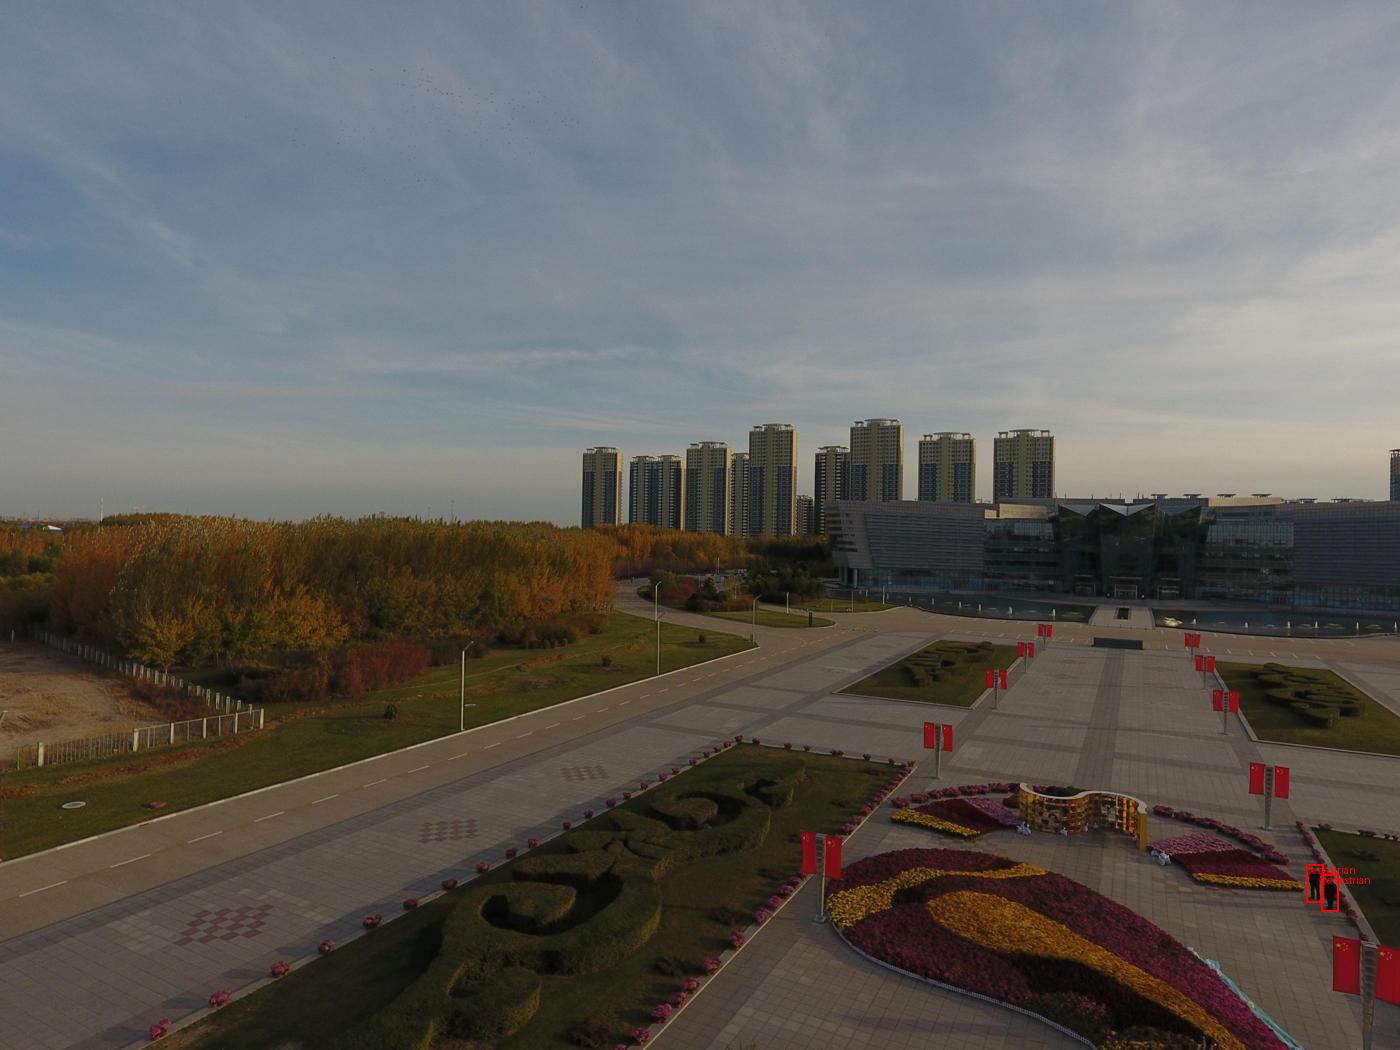

In [185]:
import io
from PIL import Image

def process_and_display(response, df, ds, unique_words, user_input):
    """Processes nodes, finds corresponding images in dataset, and displays them with bounding boxes.

    Args:
        response: The response object containing source nodes.
        df: The DataFrame with doc_id information.
        ds: The dataset containing images, labels, and boxes.
        unique_words: The list of unique words from the retrieved text.
        user_input: The original user query to find the target word.
    """
    
    # Extract the target word from user_input (e.g., "truck" from "How do drones identify a truck?")
    query_words = user_input.lower().split()
    
    # Find which unique_word appears in the query
    target_word = None
    for word in unique_words:
        if word in query_words:
            target_word = word
            break
    
    # If no match, use the most frequent word in unique_words (heuristic)
    if target_word is None:
        # Count occurrences in the node text
        node_text = response.source_nodes[0].get_text().lower()
        word_counts = {word: node_text.count(word) for word in unique_words}
        target_word = max(word_counts, key=word_counts.get)
    
    print(f"Target object to detect: {target_word}")
    
    # Extract the node and find corresponding row in DataFrame
    for node in response.source_nodes:
        related_node_info = next(iter(node.node.relationships.values()))
        original_doc_id = str(related_node_info.node_id)  # Convert to string
        
        try:
            row_index = df[df['doc_id'] == original_doc_id].index[0]
            print(f"Found match: doc_id={original_doc_id}, row_index={row_index}")
        except IndexError:
            print(f"Warning: doc_id {original_doc_id} not found in DataFrame")
            continue
        
        # Convert pandas int64 to native Python int for DeepLake compatibility
        row_index = int(row_index)
        
        # Directly access the specific image by row_index (no iteration!)
        print(f"Loading image at index {row_index}...")
        
        labels = ds.labels[row_index].data()['value']
        image_data = ds.images[row_index].tobytes()
        bboxes = ds.boxes[row_index].numpy()
        
        print(f"Displaying image with bounding boxes for: {target_word}")
        display_image_with_bboxes(image_data, bboxes, labels, label_name=target_word, ind=row_index)

# Use multimodal_response (saved in previous cell) instead of response
process_and_display(multimodal_response, df, ds, unique_words, user_input)

# Multimodal Modular Summary

Assuming the processes have been activated.

In [186]:
from PIL import Image
def display_source_image(image_path):
  try:
    with Image.open(image_path) as img:
        display(img)
  except FileNotFoundError:
    print("Error: The image file was not found at the specified path.")
  except Exception as e:  # Catch other potential errors
    print(f"Error loading image: {e}")

How do drones identify a pedestrian?
Drones can identify a truck through various means such as using computer vision technology, sensors
like Lidar, and other imaging techniques.


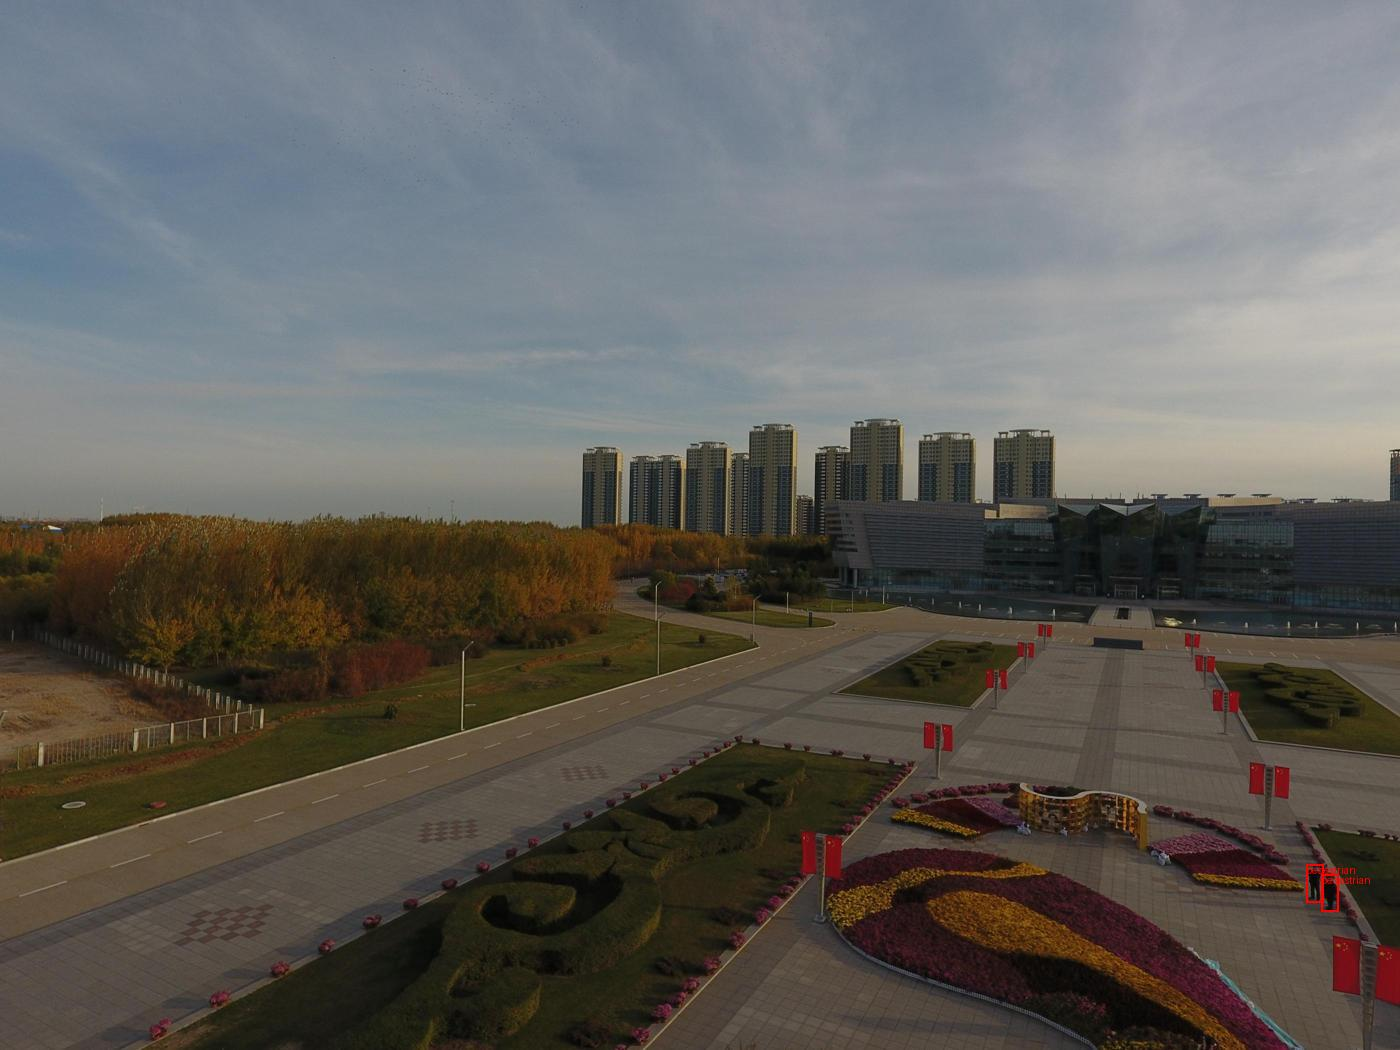

In [187]:
# 1.user input=user_input
print(user_input)
# 2.LLM response
print(textwrap.fill(str(llm_response), 100))
# 3.Multimodal reponse
image_path = "./boxed_image.jpg"
display_source_image(image_path)

# Performance metric

In [188]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity

In [189]:
from sentence_transformers import SentenceTransformer
model = SentenceTransformer('all-MiniLM-L6-v2')

def calculate_cosine_similarity_with_embeddings(text1, text2):
    embeddings1 = model.encode(text1)
    embeddings2 = model.encode(text2)
    similarity = cosine_similarity([embeddings1], [embeddings2])
    return similarity[0][0]

## LLM performance

In [190]:
llm_similarity_score = calculate_cosine_similarity_with_embeddings(user_input, str(llm_response))
print(user_input)
print(llm_response)
print(f"Cosine Similarity Score: {llm_similarity_score:.3f}")

How do drones identify a pedestrian?
Drones can identify a truck through various means such as using computer vision technology, sensors like Lidar, and other imaging techniques.
Cosine Similarity Score: 0.680


## Multimodal performance

In [191]:
import base64

IMAGE_PATH = "./boxed_image.jpg"

# Open the image file and encode it as a base64 string
def encode_image(image_path):
    with open(image_path, "rb") as image_file:
        return base64.b64encode(image_file.read()).decode("utf-8")

base64_image = encode_image(IMAGE_PATH)
base64_image

'/9j/4AAQSkZJRgABAQAAAQABAAD/2wBDAAgGBgcGBQgHBwcJCQgKDBQNDAsLDBkSEw8UHRofHh0aHBwgJC4nICIsIxwcKDcpLDAxNDQ0Hyc5PTgyPC4zNDL/2wBDAQkJCQwLDBgNDRgyIRwhMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjL/wAARCAQaBXgDASIAAhEBAxEB/8QAHwAAAQUBAQEBAQEAAAAAAAAAAAECAwQFBgcICQoL/8QAtRAAAgEDAwIEAwUFBAQAAAF9AQIDAAQRBRIhMUEGE1FhByJxFDKBkaEII0KxwRVS0fAkM2JyggkKFhcYGRolJicoKSo0NTY3ODk6Q0RFRkdISUpTVFVWV1hZWmNkZWZnaGlqc3R1dnd4eXqDhIWGh4iJipKTlJWWl5iZmqKjpKWmp6ipqrKztLW2t7i5usLDxMXGx8jJytLT1NXW19jZ2uHi4+Tl5ufo6erx8vP09fb3+Pn6/8QAHwEAAwEBAQEBAQEBAQAAAAAAAAECAwQFBgcICQoL/8QAtREAAgECBAQDBAcFBAQAAQJ3AAECAxEEBSExBhJBUQdhcRMiMoEIFEKRobHBCSMzUvAVYnLRChYkNOEl8RcYGRomJygpKjU2Nzg5OkNERUZHSElKU1RVVldYWVpjZGVmZ2hpanN0dXZ3eHl6goOEhYaHiImKkpOUlZaXmJmaoqOkpaanqKmqsrO0tba3uLm6wsPExcbHyMnK0tPU1dbX2Nna4uPk5ebn6Onq8vP09fb3+Pn6/9oADAMBAAIRAxEAPwCHFA6UvfoaK6znEHWg0UuOeaQAM9qTNKKXGe3FMBnWlJpSKTmgBM0veij2oAQ9KT6UuKTHNAgFPFMpQaQx+KTpmjOMcUZzQFxc8UUDg0ufagBAKUjmjjOadkGgY3tiginjrS4pARdMelOGKNuaUrxQA2heh4oPSjFMANApcUm

In [192]:
# Get unique words from the FIRST (best) source node
node_text = multimodal_response.source_nodes[0].get_text()
unique_words = get_unique_words(node_text)

# Find the target word that matches the user query
query_words = user_input.lower().split()
u_word = None
for word in unique_words:
    if word in query_words:
        u_word = word
        break

# Fallback: use most frequent word if no match
if u_word is None:
    word_counts = {word: node_text.lower().count(word) for word in unique_words}
    u_word = max(word_counts, key=word_counts.get)

print(f"Target word from query: {u_word}")
print(f"All unique words in first source node: {unique_words}")

Target word from query: pedestrian
All unique words in first source node: ['pedestrian']


In [193]:
import os
from openai import OpenAI

# Set the API key for the client
client = OpenAI(api_key=os.getenv("OPENAI_API_KEY"))
MODEL = "gpt-4o"
print(f"✓ OpenAI client initialized with model: {MODEL}")

✓ OpenAI client initialized with model: gpt-4o


In [194]:
response_gpt4 = client.chat.completions.create(
    model=MODEL,
    messages=[
        {"role": "system", "content": f"You are a helpful assistant that analyzes images that contain {u_word}."},
        {"role": "user", "content": [
            {"type": "text", "text": f"Analyze the following image, tell me if there is one {u_word} or more in the bounding boxes and analyse them:"},
            {"type": "image_url", "image_url": {
                "url": f"data:image/png;base64,{base64_image}"}
            }
        ]}
    ],
    temperature=0.0,
)
response_image = response_gpt4.choices[0].message.content
print(response_image)

The image contains one pedestrian within the bounding box. The pedestrian is located in a large, open plaza area with decorative landscaping and flags. The setting appears to be an urban environment with tall buildings in the background. The pedestrian is positioned near the bottom right of the image.


In [195]:
resp=user_input+u_word+"s"
multimodal_similarity_score = calculate_cosine_similarity_with_embeddings(resp, str(response_image))
print(f"Cosine Similarity Score: {multimodal_similarity_score:.3f}")

Cosine Similarity Score: 0.444


## Multimodal Modular RAG performance

In [196]:
score=(llm_similarity_score+multimodal_similarity_score)/2
print(f"Multimodal, Modular Score: {score:.3f}")

Multimodal, Modular Score: 0.562
